# Problem Statement: 
The task at hand involves classifying images of cats and dogs using a Convolutional Neural Network (CNN). We have a dataset containing images of cats and dogs and the objective is to train a CNN model to accurately predict the class of each image.

# Objectives: 

### Data Preparation: 
● Download and extract the cats vs. dogs dataset. 

● Organize the dataset into a structured directory format suitable for TensorFlow’s ImageDataGenerator. 

● Split the dataset into training and testing sets. 

### Data Augmentation and Preprocessing: 
● Implement data augmentation techniques to increase the diversity of the training dataset, aiding in the model's ability to generalize.

● Normalize the pixel values of the images for optimal model performance. 

### Model Building: 
● Construct a Convolutional Neural Network using TensorFlow and Keras. 

● Themodel should contain multiple convolutional layers, pooling layers, and fully connected layers. 

### Training: 
● Compile the model and train it on the prepared dataset. 

● Utilize categorical cross entropy as the loss function and stochastic gradient descent as the optimizer. 

● Train the model for a sufficient number of epochs to achieve good performance. 

### Evaluation: 
● Evaluate the model's performance on the validation set during training to monitor for overfitting. 

● After training, assess the model's accuracy and make predictions on the test set. 

### Prediction: 
● Implement a system to make predictions on new images, categorizing them as either cat or dog. 

● Thesystem should be able to take an image (or a batch of images), preprocess it, and pass it through the model for prediction.

# 1. Load Important Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
import zipfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout)

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

C:\Users\raman\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# 2. Download & Extract Dataset

In [2]:
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
urllib.request.urlretrieve(url, "cats_dogs.zip")

# Extract the dataset
with zipfile.ZipFile("cats_dogs.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

# 3. Preprocessing

In [3]:
def remove_corrupted_images(path):
    for filename in os.listdir(path):
        try:
            img = plt.imread(os.path.join(path, filename))
        except:
            os.remove(os.path.join(path, filename))

remove_corrupted_images("dataset/PetImages/Cat")
remove_corrupted_images("dataset/PetImages/Dog")

# 4. Train Test Directory

In [4]:
base_dir = "cats_dogs_dataset"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# 5. Create Directories

In [5]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for split_dir in [train_dir, validation_dir, test_dir]:
    os.makedirs(os.path.join(split_dir, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'dogs'), exist_ok=True)

In [6]:
# Get all cat and dog images
cat_images = [f for f in os.listdir("dataset/PetImages/Cat") if f.endswith('.jpg')]
dog_images = [f for f in os.listdir("dataset/PetImages/Dog") if f.endswith('.jpg')]

# 6. Train Test Split

In [7]:
# Split cats
train_cats, temp_cats = train_test_split(cat_images, test_size=0.2, random_state=42)
val_cats, test_cats = train_test_split(temp_cats, test_size=0.5, random_state=42)

# Split dogs
train_dogs, temp_dogs = train_test_split(dog_images, test_size=0.2, random_state=42)
val_dogs, test_dogs = train_test_split(temp_dogs, test_size=0.5, random_state=42)

In [8]:
# Move files to appropriate directories
def move_images(src_dir, image_list, dst_dir):
    for img in image_list:
        src_path = os.path.join(src_dir, img)
        dst_path = os.path.join(dst_dir, img)
        if os.path.exists(src_path):
            os.rename(src_path, dst_path)

# 7. Data Augmentation & Preprocessing

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 8. Test Data Generator (Only Normalization)

In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 9. Create Data Loaders

In [11]:
batch_size = 32
target_size = (150, 150)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 19998 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# 10. Build CNN Model

In [12]:
model = keras.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    
    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Fourth Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

# 11. Compile the Model

In [20]:
optimizer = SGD(learning_rate=0.05, momentum=0.9)

model.compile(
    loss='binary_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

# 12. Train the Model

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 357s 571ms/step - accuracy: 0.7011 - loss: 0.5728 - val_accuracy: 0.7400 - val_loss: 0.5335
Epoch 2/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7188 - loss: 0.5021 - val_accuracy: 0.7328 - val_loss: 0.5363
Epoch 3/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 360s 577ms/step - accuracy: 0.7013 - loss: 0.5710 - val_accuracy: 0.7452 - val_loss: 0.5231
Epoch 4/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.8125 - loss: 0.5375 - val_accuracy: 0.7464 - val_loss: 0.5216
Epoch 5/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 360s 576ms/step - accuracy: 0.7095 - loss: 0.5622 - val_accuracy: 0.7568 - val_loss: 0.5136
Epoch 6/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6562 - loss: 0.5956 - val_accuracy: 0.7476 - val_loss: 0.5159
Epoch 7/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 372s 596ms/step - accuracy: 0.7133 - loss: 0.5582 - val_accuracy: 0.7572 - val_loss: 0.5082
Epoch 8/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7500 - loss: 0

# 13. Model Evaluation

In [23]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.7568 - loss: 0.5025
Test Accuracy: 0.7568


# 14. Plot Training & Validation Curves

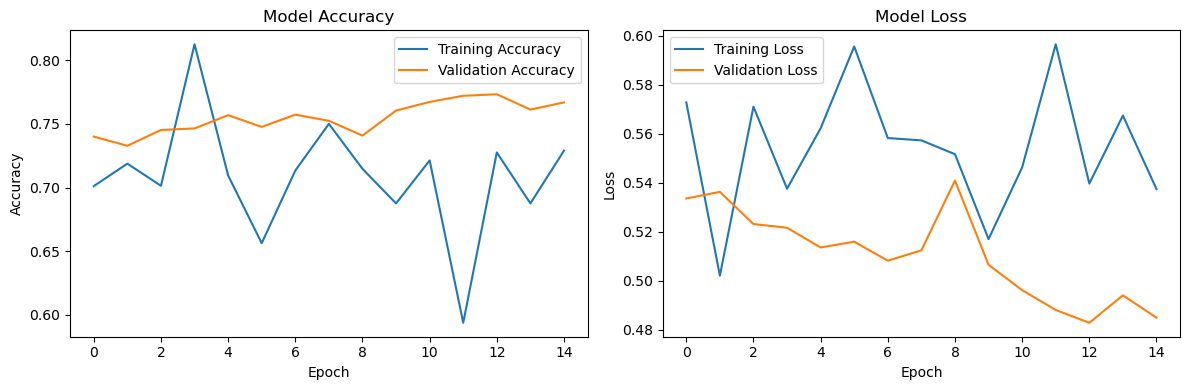

In [24]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 15. Predictions on New Images 

In [40]:
def predict_image(model, image_path, target_size=(150, 150)):

    img = keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Make prediction
    prediction = model.predict(img_array)[0][0]
    
    # Convert to class label
    class_label = 'dog' if prediction > 0.5 else 'cat'
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return {
        'prediction': class_label,
        'confidence': float(confidence),
        'probability_dog': float(prediction),
        'probability_cat': float(1 - prediction)
    }

In [43]:
image_path = r"C:\Users\raman\cats_dogs_dataset\test\dogs\2702.jpg"
print("Prediction:", predict_image(model, image_path, target_size=(150, 150)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Prediction: {'prediction': 'dog', 'confidence': 0.8615769147872925, 'probability_dog': 0.8615769147872925, 'probability_cat': 0.13842308521270752}


In [44]:
image_path = r"C:\Users\raman\cats_dogs_dataset\test\cats\2423.jpg"
print("Prediction:", predict_image(model, image_path, target_size=(150, 150)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Prediction: {'prediction': 'cat', 'confidence': 0.766854777932167, 'probability_dog': 0.23314522206783295, 'probability_cat': 0.766854777932167}
